<a href="https://colab.research.google.com/github/umairaziz719/SoundSense-Sentiment-Analysis/blob/main/soundsense.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
from google.colab import drive
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from keras.layers import Dense, LSTM, Dropout
from keras.models import Sequential
from keras.layers import Dense,Dropout, Activation, GRU
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Step 1: Mount Google Drive

drive.mount('/content/drive')

# Step 2: Clone the GitHub Repository
!git clone https://github.com/umairaziz719/SoundSense-Sentiment-Analysis.git

# Step 3: Collect Paths and Labels

paths = []
labels = []

# Define the path to the dataset
dataset_path = '/content/SoundSense-Sentiment-Analysis/TESS Toronto emotional speech set data'

# Walk through the directory and collect file paths and labels
for dirname, _, filenames in os.walk(dataset_path):
    for filename in filenames:
        file_path = os.path.join(dirname, filename)
        paths.append(file_path)

        # Extract label from the filename
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        labels.append(label.lower())

    # Break if we've collected a specified number of files, if needed
    # if len(paths) == 2800:  # Adjust this number as necessary
    #     break

print('Dataset is Loaded')


Mounted at /content/drive
Cloning into 'SoundSense-Sentiment-Analysis'...
remote: Enumerating objects: 2850, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 2850 (delta 9), reused 9 (delta 1), pack-reused 2818
Receiving objects: 100% (2850/2850), 218.80 MiB | 25.51 MiB/s, done.
Resolving deltas: 100% (10/10), done.
Updating files: 100% (2802/2802), done.
Dataset is Loaded


In [3]:
len(paths)

2800

In [4]:
paths[:5]

['/content/SoundSense-Sentiment-Analysis/TESS Toronto emotional speech set data/YAF_neutral/YAF_raid_neutral.wav',
 '/content/SoundSense-Sentiment-Analysis/TESS Toronto emotional speech set data/YAF_neutral/YAF_dodge_neutral.wav',
 '/content/SoundSense-Sentiment-Analysis/TESS Toronto emotional speech set data/YAF_neutral/YAF_nice_neutral.wav',
 '/content/SoundSense-Sentiment-Analysis/TESS Toronto emotional speech set data/YAF_neutral/YAF_sub_neutral.wav',
 '/content/SoundSense-Sentiment-Analysis/TESS Toronto emotional speech set data/YAF_neutral/YAF_knock_neutral.wav']

In [5]:
labels[:5]

['neutral', 'neutral', 'neutral', 'neutral', 'neutral']

In [6]:
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels
df.head()

,speech,label
0,/content/SoundSense-Sentiment-Analysis/TESS To...,neutral
1,/content/SoundSense-Sentiment-Analysis/TESS To...,neutral
2,/content/SoundSense-Sentiment-Analysis/TESS To...,neutral
3,/content/SoundSense-Sentiment-Analysis/TESS To...,neutral
4,/content/SoundSense-Sentiment-Analysis/TESS To...,neutral


In [7]:
print("Data Types of DataFrame Columns:")
print(df.dtypes)

Data Types of DataFrame Columns:
speech    object
label     object
dtype: object


In [8]:
df['label'].value_counts()

label
neutral    400
disgust    400
sad        400
happy      400
ps         400
fear       400
angry      400
Name: count, dtype: int64

<Axes: xlabel='label', ylabel='count'>

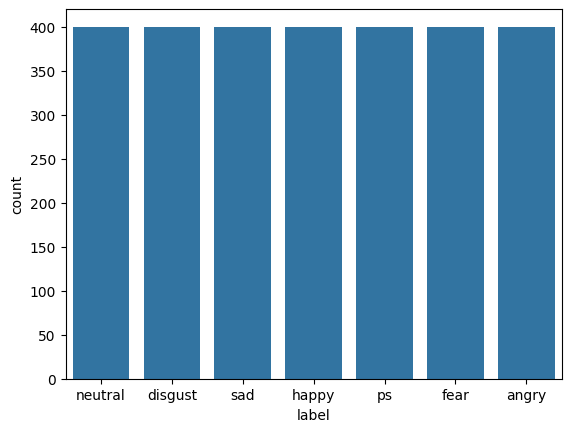

In [9]:
sns.countplot(data=df, x='label')

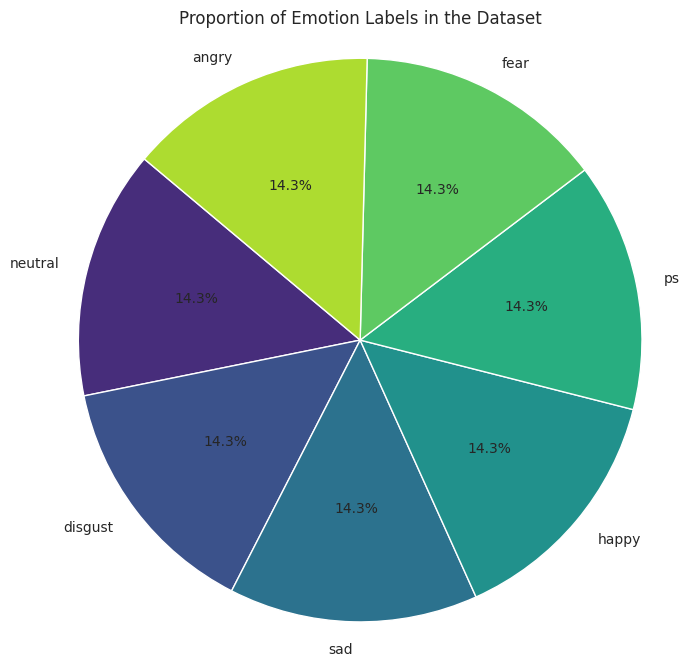

In [10]:
# Get label counts
label_counts = df['label'].value_counts()
# Data for the pie chart
labels = label_counts.index
counts = label_counts.values
colors = sns.color_palette('viridis', len(labels))
# Set Seaborn style
sns.set_style("whitegrid")
# Plot
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Proportion of Emotion Labels in the Dataset')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.show()

In [11]:
def plot_with_title(emotion, title, figsize=(10, 4), size=20):
    plt.figure(figsize=figsize)
    plt.title(f"{emotion}: {title}", fontsize=size, fontweight='bold', color='navy')

def waveplot(data, sr, emotion):
    plot_with_title(emotion, "Waveform")
    librosa.display.waveshow(data, sr=sr, color='dodgerblue', alpha=0.8, linewidth=1.5)
    plt.xlabel('Time (s)', fontsize=15, fontweight='bold', color='darkslategray')
    plt.ylabel('Amplitude', fontsize=15, fontweight='bold', color='darkslategray')
    plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
    plt.tight_layout()
    plt.show()

def mfcc(data, sr, emotion):
    mfccs = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=13)
    plot_with_title(emotion, "MFCCs", figsize=(10, 6))
    librosa.display.specshow(mfccs, sr=sr, x_axis='time')
    plt.colorbar()
    plt.xlabel('Time (s)', fontsize=15, fontweight='bold', color='darkslategray')
    plt.ylabel('MFCC Coefficients', fontsize=15, fontweight='bold', color='darkslategray')
    plt.tight_layout()
    plt.show()

def zero_crossing_rate(data, sr, emotion):
    zcr = librosa.feature.zero_crossing_rate(y=data)
    plot_with_title(emotion, "Zero Crossing Rate", figsize=(10, 4))
    plt.plot(zcr[0], color='crimson')
    plt.xlabel('Frame', fontsize=15, fontweight='bold', color='darkslategray')
    plt.ylabel('ZCR', fontsize=15, fontweight='bold', color='darkslategray')
    plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
    plt.tight_layout()
    plt.show()


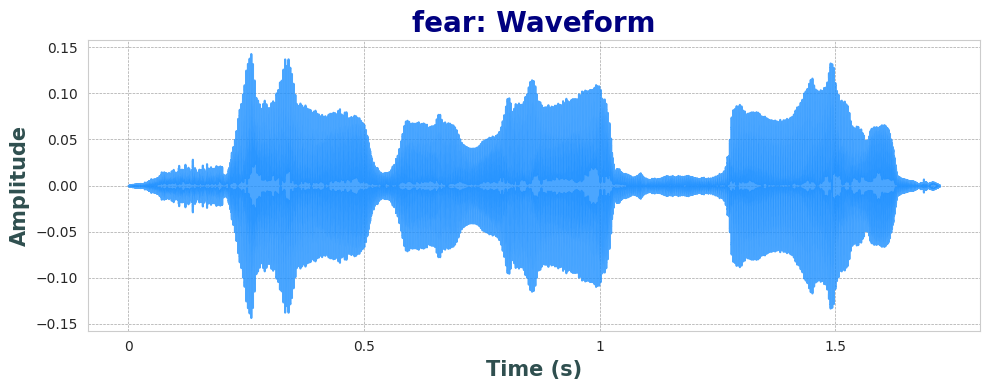

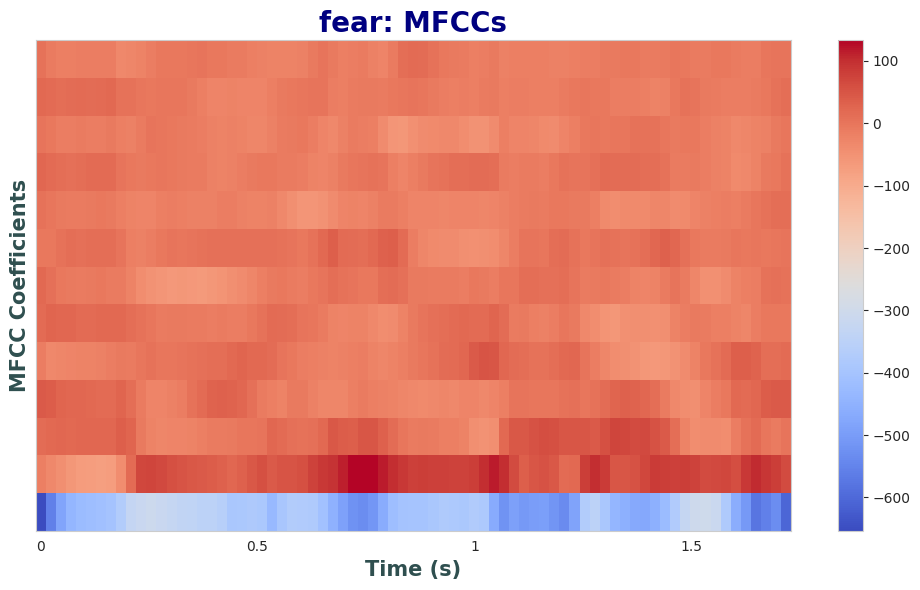

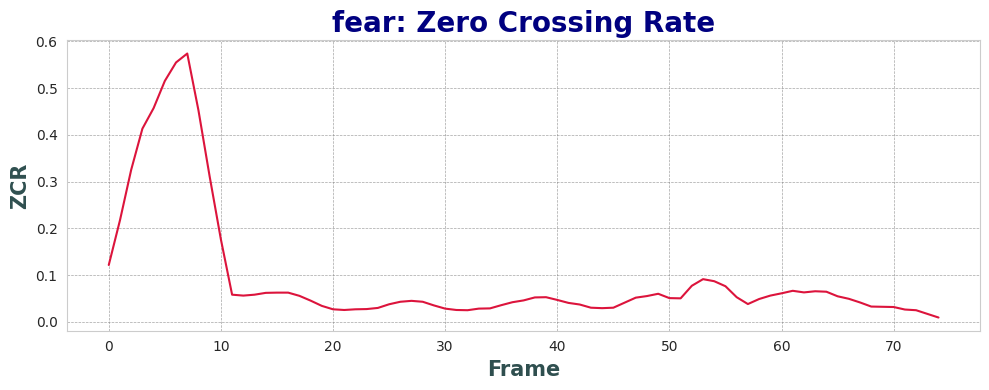

In [12]:
emotion = 'fear'
path = df.loc[df['label'] == emotion, 'speech'].values[0]
# Load the audio file
data, sampling_rate = librosa.load(path)
# Plot the waveplot
waveplot(data, sampling_rate, emotion)
# Plot the MFCCs
mfcc(data, sampling_rate, emotion)
# Plot the zero-crossing rate
zero_crossing_rate(data, sampling_rate, emotion)
# Display the audio player
Audio(path)

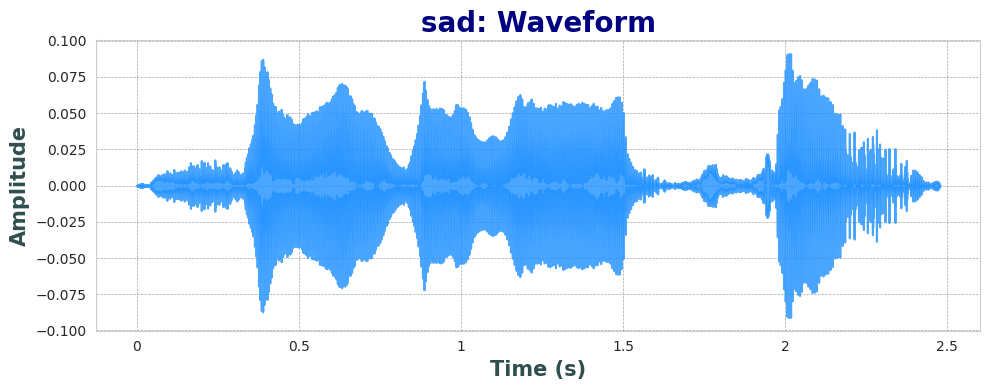

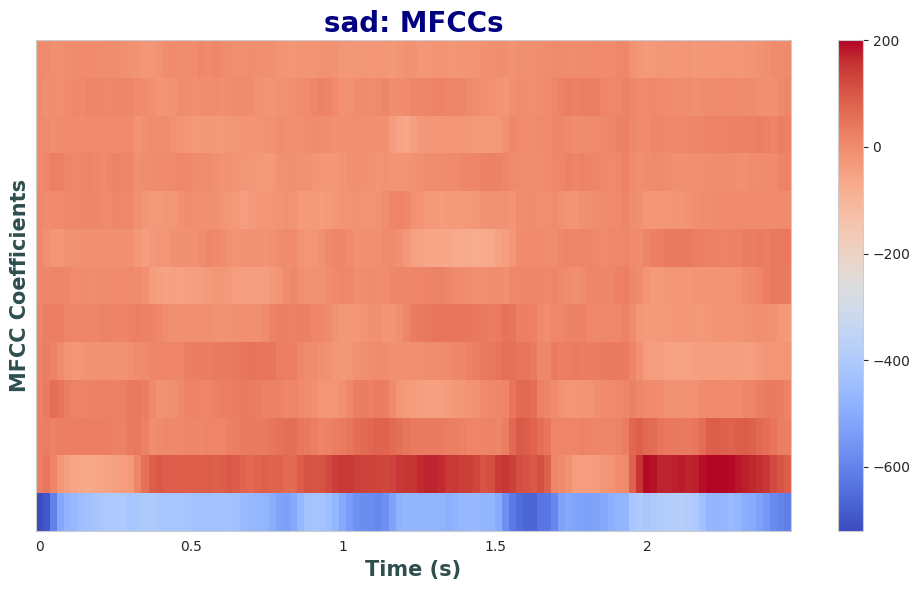

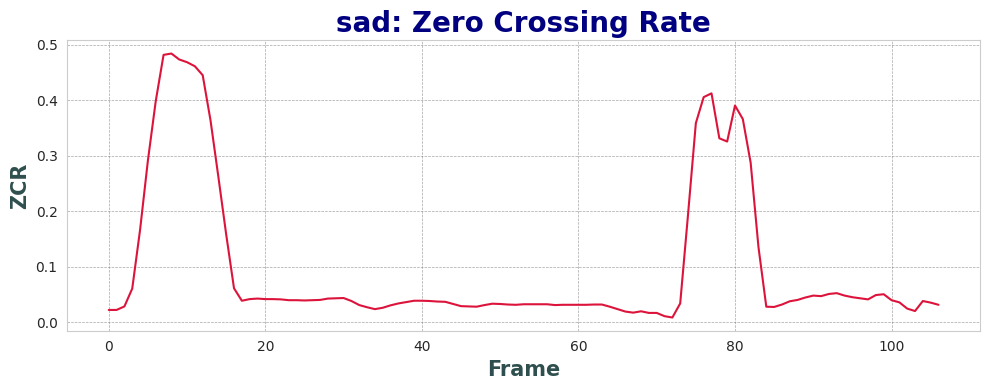

In [13]:
emotion = 'sad'
path = df.loc[df['label'] == emotion, 'speech'].values[0]
# Load the audio file
data, sampling_rate = librosa.load(path)
# Plot the waveplot
waveplot(data, sampling_rate, emotion)
# Plot the MFCCs
mfcc(data, sampling_rate, emotion)
# Plot the zero-crossing rate
zero_crossing_rate(data, sampling_rate, emotion)
# Display the audio player
Audio(path)

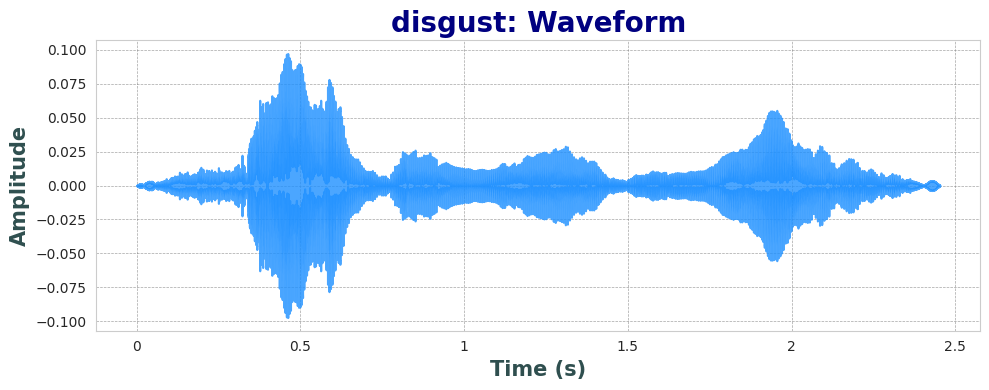

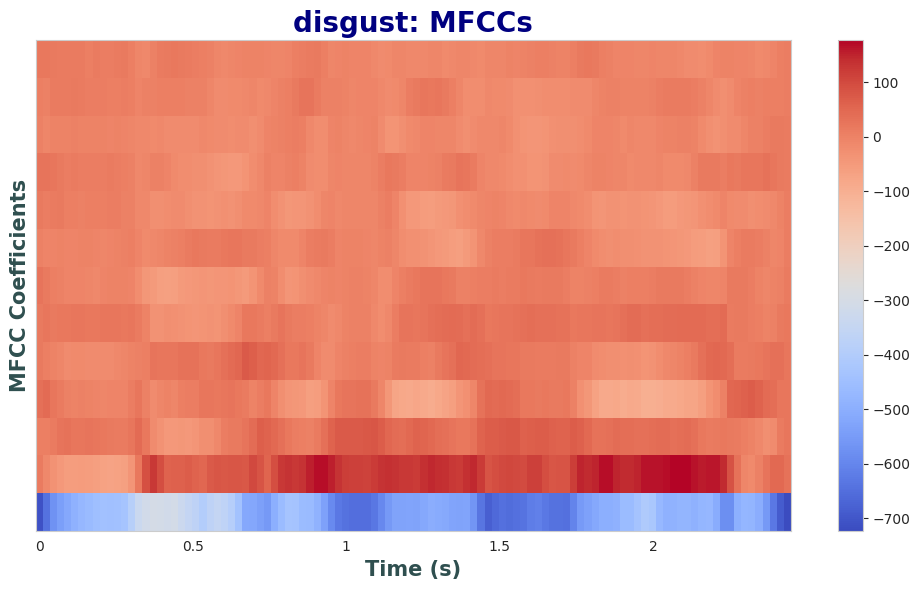

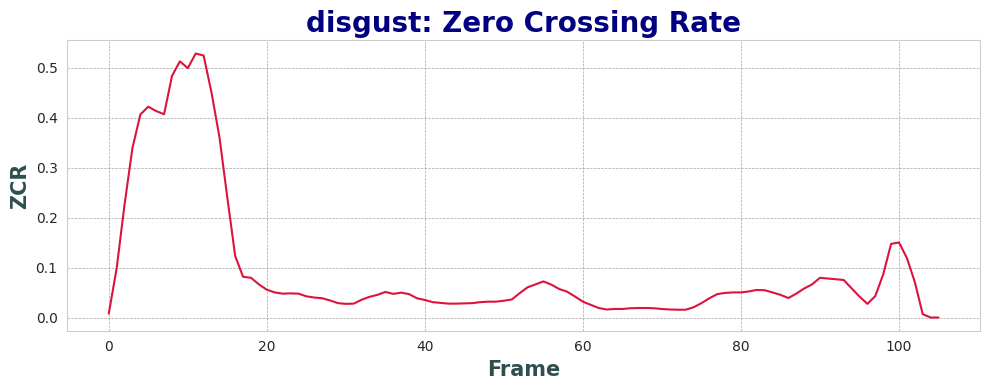

In [14]:
emotion = 'disgust'
path = df.loc[df['label'] == emotion, 'speech'].values[0]
# Load the audio file
data, sampling_rate = librosa.load(path)
# Plot the waveplot
waveplot(data, sampling_rate, emotion)
# Plot the MFCCs
mfcc(data, sampling_rate, emotion)
# Plot the zero-crossing rate
zero_crossing_rate(data, sampling_rate, emotion)
# Display the audio player
Audio(path)

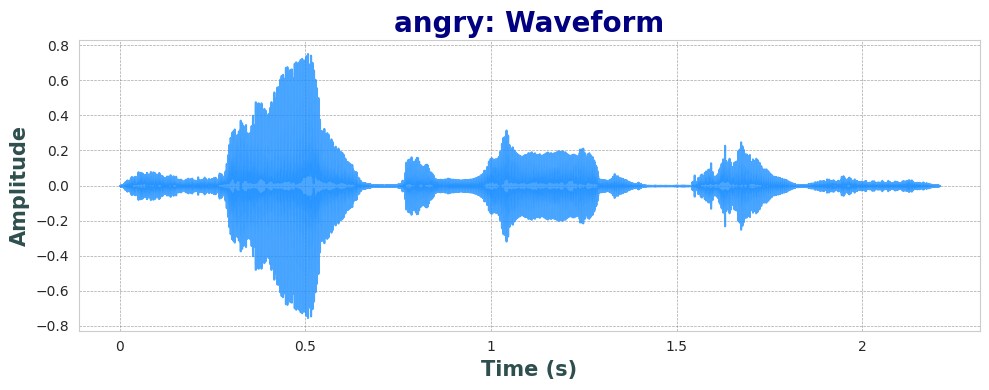

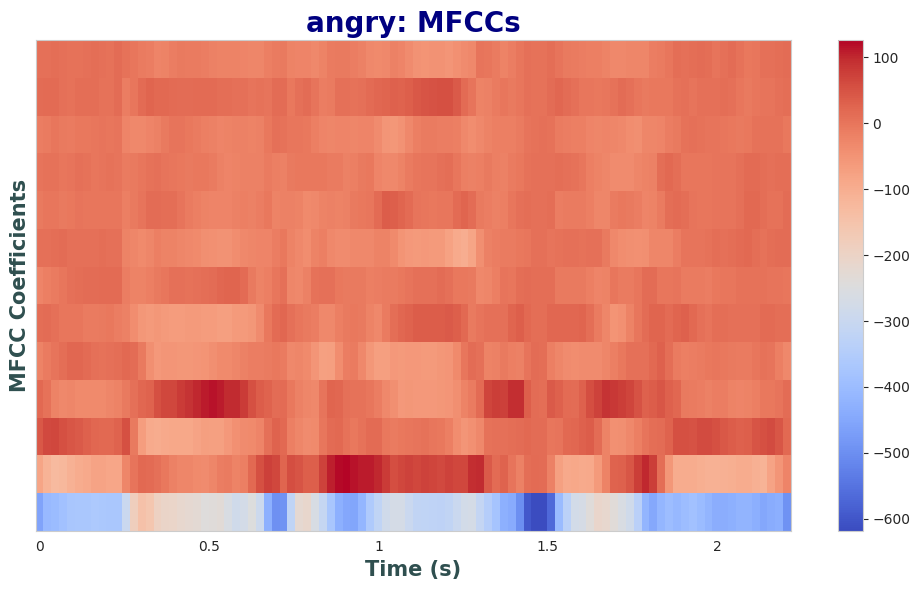

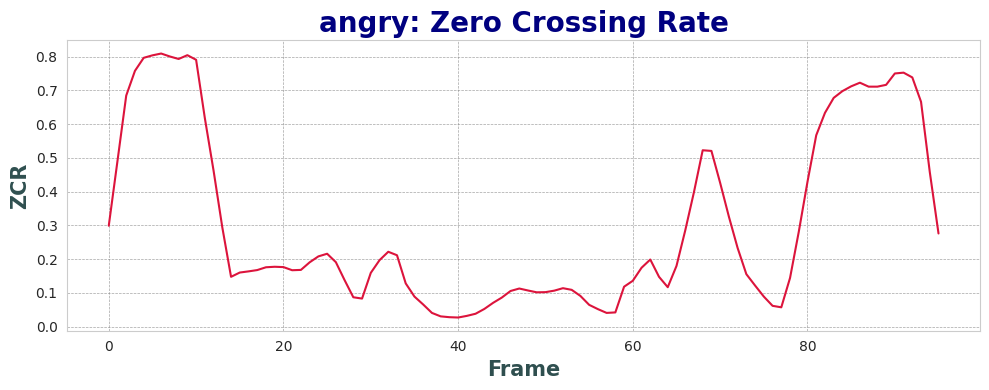

In [15]:
emotion = 'angry'
path = df.loc[df['label'] == emotion, 'speech'].values[0]
# Load the audio file
data, sampling_rate = librosa.load(path)
# Plot the waveplot
waveplot(data, sampling_rate, emotion)
# Plot the MFCCs
mfcc(data, sampling_rate, emotion)
# Plot the zero-crossing rate
zero_crossing_rate(data, sampling_rate, emotion)
# Display the audio player
Audio(path)

In [16]:
def extract_mfcc(filename, duration=3, offset=0.5, n_mfcc=40):
    """
    Extracts the mean Mel Frequency Cepstral Coefficients (MFCC) from an audio file.

    Parameters:
        filename (str): Path to the audio file.
        duration (float): Duration of the audio to be loaded (in seconds). Default is 3 seconds.
        offset (float): Start reading after this time (in seconds). Default is 0.5 seconds.
        n_mfcc (int): Number of MFCCs to extract. Default is 40.

    Returns:
        np.ndarray: Array containing the mean MFCC values.
    """
    try:
        # Load the audio file
        audio_data, sample_rate = librosa.load(filename, duration=duration, offset=offset)

        # Extract MFCC features
        mfcc_features = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=n_mfcc)

        # Calculate the mean MFCC across time
        mean_mfcc = np.mean(mfcc_features.T, axis=0)

        return mean_mfcc

    except Exception as e:
        print(f"Error processing file {filename}: {e}")
        return None

In [17]:
def get_mfcc_features(speech):
    return extract_mfcc(speech)

In [18]:
# Extract MFCC features for all speech samples in the dataframe
X_mfcc = df['speech'].apply(get_mfcc_features)

In [19]:
# Convert the list of MFCC feature arrays into a numpy array
X = np.array([x for x in X_mfcc])

# Check the shape of the resulting feature array
print(X.shape)

(2800, 40)


In [20]:
# Expand dimensions to match the expected input shape for neural networks
X = np.expand_dims(X, -1)

# Check the shape after expanding dimensions
print(X.shape)

(2800, 40, 1)


In [21]:
# One-hot encode the labels
encoder = OneHotEncoder()
y = encoder.fit_transform(df[['label']]).toarray()

# Check the shape of the encoded labels
print(y.shape)

(2800, 7)


In [22]:
# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shapes of the resulting training and validation sets
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(2240, 40, 1) (560, 40, 1) (2240, 7) (560, 7)


In [23]:
from keras import layers
model = Sequential([
    Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=5, strides=2, padding='same'),
    Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'),
    MaxPooling1D(pool_size=5, strides=2, padding='same'),
    Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'),
    MaxPooling1D(pool_size=5, strides=2, padding='same'),
    Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'),
    MaxPooling1D(pool_size=5, strides=2, padding='same'),
    Conv1D(32, kernel_size=5, strides=1, padding='same', activation='relu'),
    MaxPooling1D(pool_size=5, strides=2, padding='same'),
    Dropout(0.2),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(7, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 40, 256)           1536      
                                                                 
 max_pooling1d (MaxPooling1  (None, 20, 256)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 20, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 10, 256)           0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 10, 128)           163968    
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 5, 128)            0

In [24]:
import tensorflow as tf
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [25]:
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stop])

Epoch 1/50
35/35 [==============================] - 8s 155ms/step - loss: 2.8840 - accuracy: 0.2308 - val_loss: 1.4539 - val_accuracy: 0.4036
Epoch 2/50
35/35 [==============================] - 5s 134ms/step - loss: 1.2273 - accuracy: 0.5290 - val_loss: 0.8015 - val_accuracy: 0.8000
Epoch 3/50
35/35 [==============================] - 7s 206ms/step - loss: 0.8632 - accuracy: 0.6737 - val_loss: 0.4008 - val_accuracy: 0.8768
Epoch 4/50
35/35 [==============================] - 5s 136ms/step - loss: 0.6328 - accuracy: 0.7763 - val_loss: 0.2979 - val_accuracy: 0.8929
Epoch 5/50
35/35 [==============================] - 6s 164ms/step - loss: 0.4761 - accuracy: 0.8344 - val_loss: 0.3101 - val_accuracy: 0.8875
Epoch 6/50
35/35 [==============================] - 6s 184ms/step - loss: 0.4471 - accuracy: 0.8491 - val_loss: 0.1989 - val_accuracy: 0.9411
Epoch 7/50
35/35 [==============================] - 5s 135ms/step - loss: 0.2477 - accuracy: 0.9241 - val_loss: 0.1828 - val_accuracy: 0.9393
Epoch 

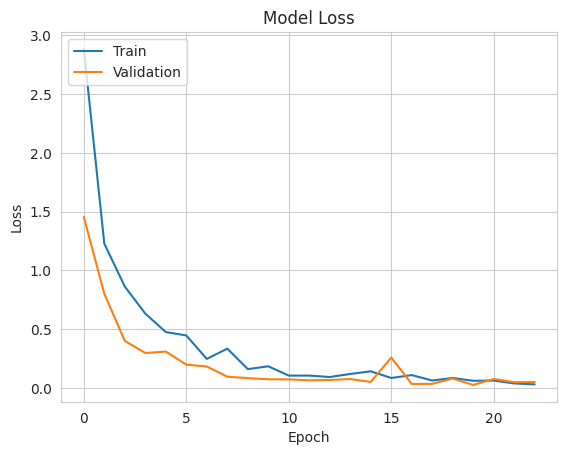

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [27]:
sample_size = 10
y_pred = model.predict(X_val[:sample_size])

# Convert predictions back from one-hot encoding
y_pred_labels = encoder.inverse_transform(y_pred)
y_val_labels = encoder.inverse_transform(y_val[:sample_size])

# Print predictions and actual values
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred_labels.flatten()
df['Actual Labels'] = y_val_labels.flatten()
df

1/1 [==============================] - 0s 197ms/step
Predictions: [['sad']
 ['sad']
 ['ps']
 ['sad']
 ['disgust']
 ['fear']
 ['ps']
 ['fear']
 ['angry']
 ['sad']]
Actual values: [['sad']
 ['sad']
 ['ps']
 ['sad']
 ['disgust']
 ['fear']
 ['ps']
 ['fear']
 ['angry']
 ['sad']]


,Predicted Labels,Actual Labels
0,sad,sad
1,sad,sad
2,ps,ps
3,sad,sad
4,disgust,disgust
5,fear,fear
6,ps,ps
7,fear,fear
8,angry,angry
9,sad,sad


In [38]:
confusion_matrix = confusion_matrix(y_val_labels,y_pred_labels)

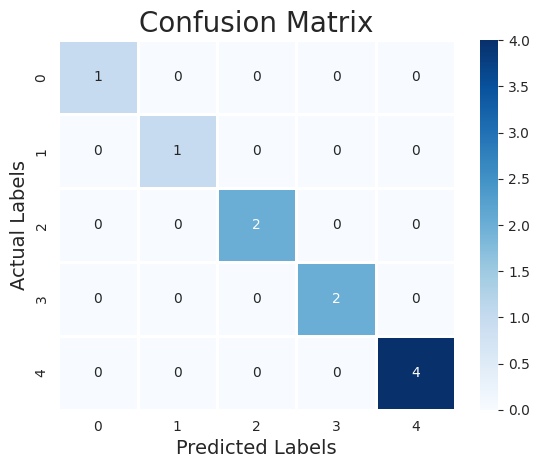

In [39]:
sns.heatmap(confusion_matrix, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')

plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [28]:
model1 = Sequential([
    LSTM(256, return_sequences=False, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(7, activation='softmax')
])

model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               264192    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 7)                

In [43]:
history1 = model1.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stop])

Epoch 1/50
35/35 [==============================] - 11s 310ms/step - loss: 0.1175 - accuracy: 0.9652 - val_loss: 0.0617 - val_accuracy: 0.9821
Epoch 2/50
35/35 [==============================] - 13s 386ms/step - loss: 0.0449 - accuracy: 0.9853 - val_loss: 0.0683 - val_accuracy: 0.9786
Epoch 3/50
35/35 [==============================] - 9s 242ms/step - loss: 0.0524 - accuracy: 0.9812 - val_loss: 0.1406 - val_accuracy: 0.9661
Epoch 4/50
35/35 [==============================] - 9s 251ms/step - loss: 0.0791 - accuracy: 0.9728 - val_loss: 0.0591 - val_accuracy: 0.9821
Epoch 5/50
35/35 [==============================] - 6s 175ms/step - loss: 0.0426 - accuracy: 0.9866 - val_loss: 0.1424 - val_accuracy: 0.9482
Epoch 6/50
35/35 [==============================] - 8s 229ms/step - loss: 0.0474 - accuracy: 0.9862 - val_loss: 0.0706 - val_accuracy: 0.9821
Epoch 7/50
35/35 [==============================] - 6s 174ms/step - loss: 0.0323 - accuracy: 0.9893 - val_loss: 0.1116 - val_accuracy: 0.9732


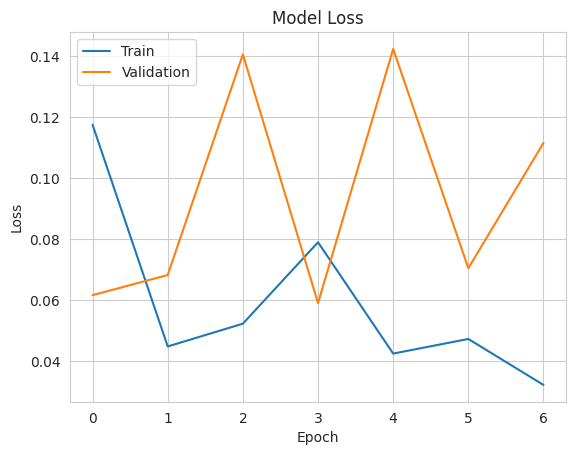

In [44]:
# Example plotting training history
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [48]:
sample_size = 10
y_pred = model1.predict(X_val[:sample_size])

# Convert predictions back from one-hot encoding
y_pred_labels = encoder.inverse_transform(y_pred)
y_val_labels = encoder.inverse_transform(y_val[:sample_size])

# Print predictions and actual values
print("Predictions:", y_pred_labels)
print("Actual values:", y_val_labels)

1/1 [==============================] - 0s 36ms/step
Predictions: [['sad']
 ['sad']
 ['ps']
 ['sad']
 ['disgust']
 ['fear']
 ['ps']
 ['fear']
 ['angry']
 ['sad']]
Actual values: [['sad']
 ['sad']
 ['ps']
 ['sad']
 ['disgust']
 ['fear']
 ['ps']
 ['fear']
 ['angry']
 ['sad']]


In [49]:
confusion_matrix = confusion_matrix(y_val_labels,y_pred_labels)

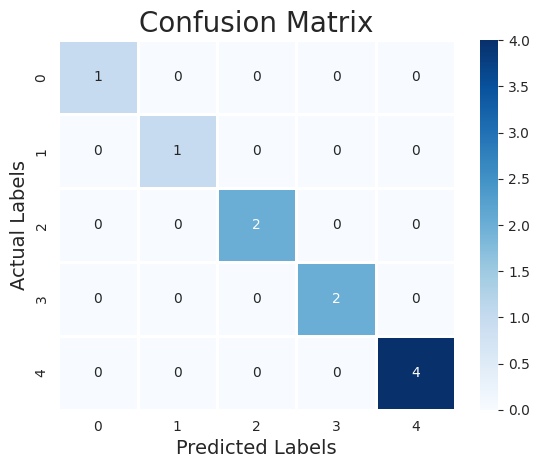

In [50]:
sns.heatmap(confusion_matrix, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')

plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [32]:
model2 = Sequential([
    GRU(123, return_sequences = False, input_shape = (40, 1)),
    Dense(64, activation = 'relu'),
    Dropout(0.2),
    Dense(32, activation = 'relu'),
    Dropout(0.2),
    Dense(7, activation = 'softmax')

])

model2.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 123)               46494     
                                                                 
 dense_5 (Dense)             (None, 64)                7936      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 7)                 231       
                                                                 
Total params: 56741 (221.64 KB)
Trainable params: 5674

In [33]:
#Training the model
history2 = model2.fit(X, y, validation_split = 0.2, epochs = 100, batch_size = 512, shuffle = True)

Epoch 1/100
5/5 [==============================] - 6s 447ms/step - loss: 1.9006 - accuracy: 0.2473 - val_loss: 2.0280 - val_accuracy: 0.0000e+00
Epoch 2/100
5/5 [==============================] - 1s 238ms/step - loss: 1.7160 - accuracy: 0.4036 - val_loss: 2.1212 - val_accuracy: 0.0000e+00
Epoch 3/100
5/5 [==============================] - 1s 228ms/step - loss: 1.5395 - accuracy: 0.4759 - val_loss: 2.2232 - val_accuracy: 0.0000e+00
Epoch 4/100
5/5 [==============================] - 1s 260ms/step - loss: 1.4031 - accuracy: 0.4960 - val_loss: 2.3760 - val_accuracy: 0.0000e+00
Epoch 5/100
5/5 [==============================] - 1s 232ms/step - loss: 1.2556 - accuracy: 0.5415 - val_loss: 2.6279 - val_accuracy: 0.0000e+00
Epoch 6/100
5/5 [==============================] - 1s 224ms/step - loss: 1.1292 - accuracy: 0.5589 - val_loss: 3.0352 - val_accuracy: 0.0000e+00
Epoch 7/100
5/5 [==============================] - 1s 245ms/step - loss: 1.0150 - accuracy: 0.6076 - val_loss: 3.6107 - val_accura

KeyboardInterrupt: 

In [ ]:
# Example plotting training history
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
sample_size = 10
y_pred = model2.predict(X_val[:sample_size])

# Convert predictions back from one-hot encoding
y_pred_labels = encoder.inverse_transform(y_pred)
y_val_labels = encoder.inverse_transform(y_val[:sample_size])

# Print predictions and actual values
print("Predictions:", y_pred_labels)
print("Actual values:", y_val_labels)

In [ ]:
confusion_matrix = confusion_matrix(y_val_labels,y_pred_labels)

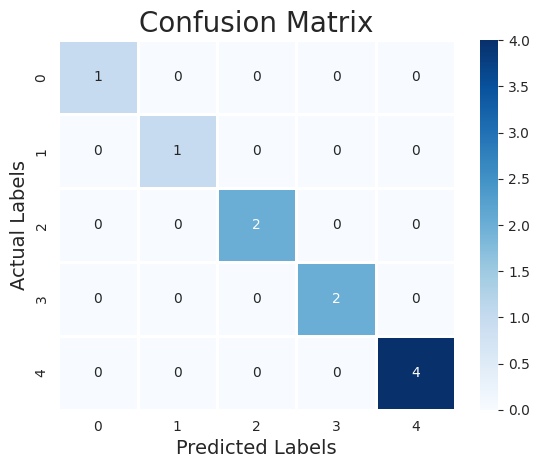

In [51]:
sns.heatmap(confusion_matrix, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')

plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
# Extract MFCC features for all speech samples in the dataframe
X_mfcc = df['speech'].apply(extract_mfcc)
# Convert the list of MFCC feature arrays into a numpy array
X = np.array([x for x in X_mfcc])

In [ ]:
# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
# One-hot encode the labels
encoder = OneHotEncoder()
y = encoder.fit_transform(df[['label']]).toarray()

In [ ]:
# Convert one-hot encoded labels back to single label for SVM
y_labels = np.argmax(y, axis=1)
# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y_labels, test_size=0.2, random_state=42)

In [ ]:
# Train SVM model
svm_model = SVC(kernel='linear', C=1)
svm_model.fit(X_train, y_train)

In [ ]:
# Evaluate the model
y_pred = svm_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred, target_names=encoder.categories_[0])
print(f"Accuracy: {accuracy}")
print("Classification Report:\n", report)